# Introdução

O Telegram é uma plataforma de mensagens instantâneas distribuídas gratuitamente e, em grande parte, de código aberto. Sua popularidade entre desenvolvedores é grande, especialmente pela implementação pioneira de chatbots, permitindo a criação de diversas automações. Um dos cenários possíveis é a construção de pipelines de dados que capturam mensagens em tempo real para posterior análise.

Neste projeto, desenvolvi um pipeline de dados que ingere, processa, armazena e expõe mensagens de um grupo do Telegram. Esse pipeline permite que profissionais de dados realizem análises elaboradas das mensagens capturadas.

A arquitetura é dividida em duas partes: transacional e analítica. No Telegram, as mensagens são produzidas, e, na Amazon Web Services (AWS), os dados são processados ​​e analisados. O Telegram atua como fonte transacional, e as mensagens enviadas pelos usuários do grupo são capturadas por um bot, utilizando a API de bots do Telegram.

# 1. Configuração do Bot no Telegram


### 1.1 Criação do Bot

A primeira etapa foi criar o bot, responsável por capturar as mensagens enviadas no grupo do Telegram. Para isso, utilizei o BotFather, que é a ferramenta oficial do Telegram para gerenciamento de bots.



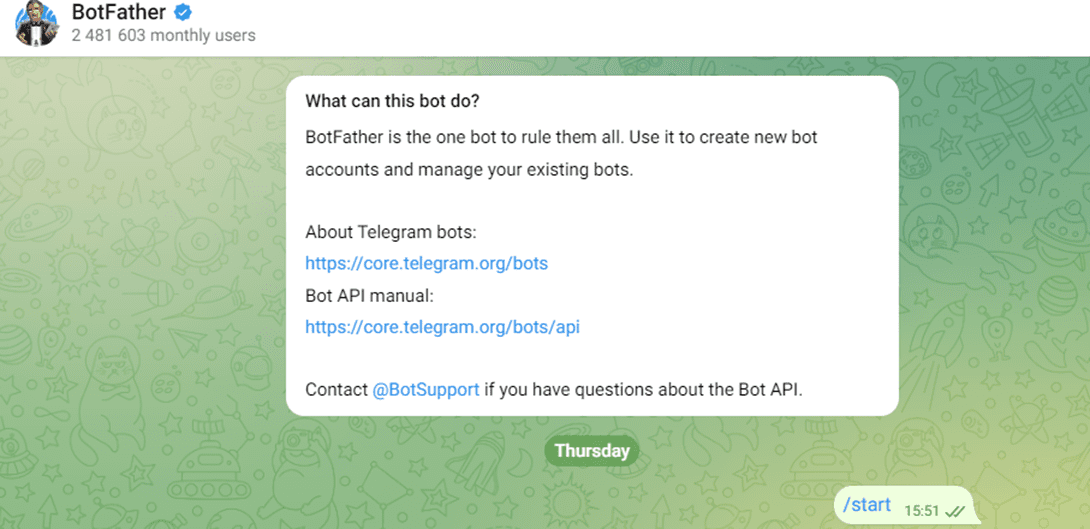

1.   Iniciei um chat com o BotFathere enviei o comando /newbot.
2.   Nomeei o bot como "DataBot_M42" e escolhi o nome de usuário "DataM42_bot".
3. Após a criação, recebi o token de acesso à API HTTP, que foi armazenado em um local seguro.

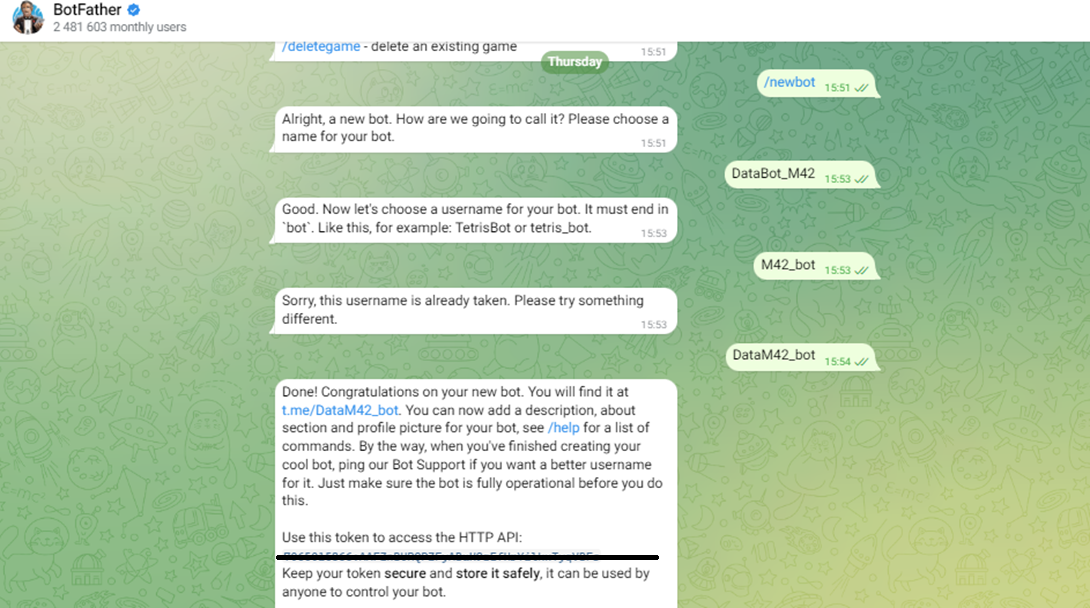

### 1.2 Configuração do Grupo no Telegram



Depois de criar o bot, precisei configurar um grupo no Telegram para que o bot pudesse capturar as mensagens.



1.   Criei um novo grupo chamado "Data Group" e adicionei o bot "DataBot_M42" ao grupo.
2.   Configurei o bot como administrador do grupo para garantir que ele tivesse acesso completo às mensagens.
3. Inclui uma breve descrição no grupo avisando que as mensagens serão armazenadas pelo bot: **Atenção, todas as mensagens são armazenadas pelo bot do grupo**

### 1.3 API de bots

Como as mensagens captadas pelo bot podem ser acessadas via API, a única informação necessária é o token fornecido pelo `BotFather` durante a criação do bot. Esse token é fundamental para realizar requisições HTTP e acessar os dados das mensagens.


Para proteger o token, utilizei o comando `getpass()` que permite a inserção segura das informações.

In [ ]:
from getpass import getpass

token = getpass()

··········


Uma URL base, que será usada para todos os métodos da API, segue o seguinte padrão:

In [ ]:
import json

import requests

base_url = f'https://api.telegram.org/bot{token}'

Para manipular as mensagens capturadas, utilizei as bibliotecas `requests`e `json`. A partir dessa URL base, podemos chamar diversos métodos da API. Por exemplo:



*   **getMe** : Esse método retorna informações sobre o bot, confirmando que ele está


In [ ]:
response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))


https://api.telegram.org/bot7065015866:AAFZnBURQPZFyABuK9zEfHrYilkxTyqVBFs/getMe
{
  "ok": true,
  "result": {
    "id": 7065015866,
    "is_bot": true,
    "first_name": "DataBot_M42",
    "username": "DataM42_bot",
    "can_join_groups": true,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false,
    "can_connect_to_business": false,
    "has_main_web_app": false
  }
}


* **getUpdates** : Esse método retorna as mensagens captadas pelo bot no grupo.

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))


{
  "ok": true,
  "result": [
    {
      "update_id": 967743632,
      "message": {
        "message_id": 16,
        "from": {
          "id": 6389278058,
          "is_bot": false,
          "first_name": "Denise",
          "last_name": "Schuartz",
          "language_code": "en"
        },
        "chat": {
          "id": -1002404175707,
          "title": "M42 EBAC Group",
          "type": "supergroup"
        },
        "date": 1726516250,
        "text": "Oie"
      }
    },
    {
      "update_id": 967743633,
      "message": {
        "message_id": 17,
        "from": {
          "id": 6389278058,
          "is_bot": false,
          "first_name": "Denise",
          "last_name": "Schuartz",
          "language_code": "en"
        },
        "chat": {
          "id": -1002404175707,
          "title": "M42 EBAC Group",
          "type": "supergroup"
        },
        "date": 1726516288,
        "text": "Hello, World"
      }
    },
    {
      "update_id": 967743634,
     

Nota: A documentação completa da API de bots do Telegram pode ser acessada neste [link](https://core.telegram.org/bots/api) .

---
Parte 2

---


* **Arquitetura**

vamos construir um pipeline de dados que ingira, processe, armazene e exponha mensagens de um grupo do Telegram para que profissionais de dados possam realizar análises. A arquitetura proposta é dividida em duas: transacional, no Telegram, onde os dados são produzidos, e analítica, na Amazon Web Services (AWS), onde os dados são analisados.

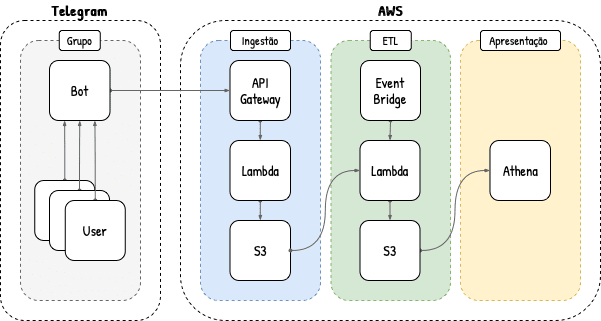

 - **Telegram**

O `Telegram` representa a fonte de dados transacionais. Mensagens enviadas por usuários em um grupo são capturadas por um *bot* e redirecionadas via *webhook* do *backend* do aplicativo para um *endpoint* (endereço *web* que aceita requisições HTTP) exposto pelo `AWS API Gateway`. As mensagens trafegam no corpo ou *payload* da requisição.

 - **AWS | Ingestão**

Uma requisição HTTP com o conteúdo da mensagem em seu *payload* é recebia pelo `AWS API Gateway` que, por sua vez, as redireciona para o `AWS Lambda`, servindo assim como seu gatilho. Já o `AWS Lambda` recebe o *payload* da requisição em seu parâmetro *event*, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o *payload*) e o armazena no `AWS S3` particionado por dia.

 - **AWS | ETL**

Uma vez ao dia, o `AWS Event Bridge` aciona o `AWS Lambda` que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no `AWS S3` particionado por dia.

 - **AWS | Apresentação**

Por fim, uma tabela do `AWS Athena` é apontada para o *bucket* do `AWS S3` que armazena o dado processado: denormalizado, particionado e orientado a coluna. Profissionais de dados podem então executar consultas analíticas (agregações, ordenações, etc.) na tabela utilizando o SQL para a extração de *insights*.